In [28]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

In [29]:
#breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)
breast_img = glob.glob('/kaggle/input/idc-data-2-sample/IDC_Data_2_Sample/Original/*/*.png', recursive = True)
for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/idc-data-2-sample/IDC_Data_2_Sample/Original/0/13591_idx5_x2951_y651_class0.png
/kaggle/input/idc-data-2-sample/IDC_Data_2_Sample/Original/0/13666_idx5_x1151_y251_class0.png
/kaggle/input/idc-data-2-sample/IDC_Data_2_Sample/Original/0/13024_idx5_x551_y601_class0.png


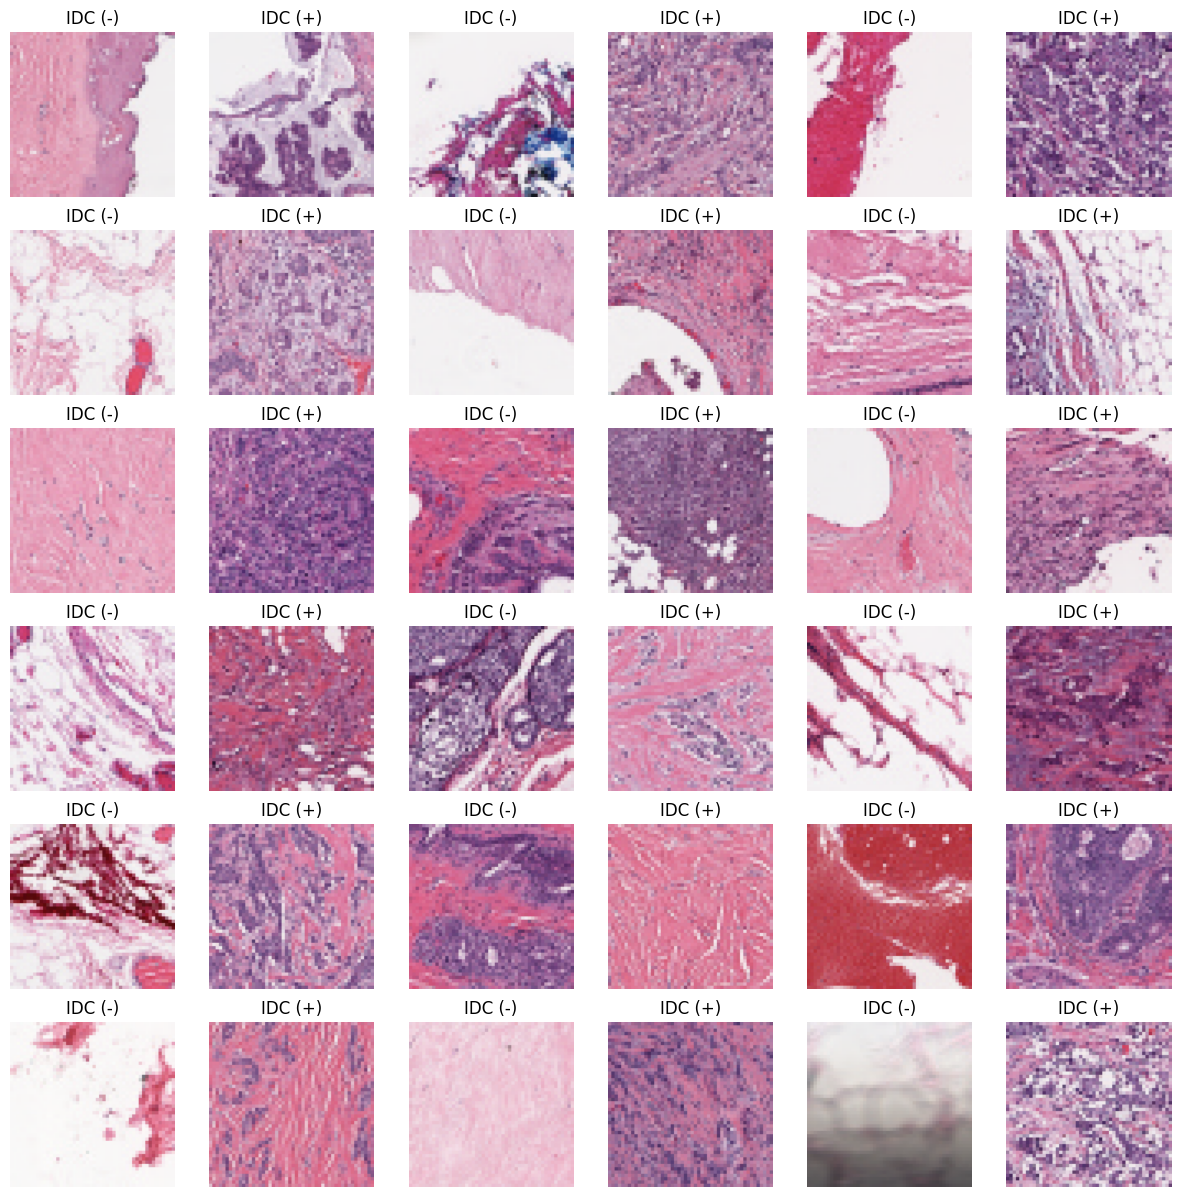

In [30]:
N_IDC = []
P_IDC = []

for img in breast_img:
    #if img[-5] == '0' :
    if 'class0' in img:
        N_IDC.append(img)
    elif 'class1' in img:
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('IDC (-)')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [31]:
print(len(N_IDC))
print(len(P_IDC))

10000
10000


In [32]:
#N_IDC=N_IDC[:50000]
#P_IDC = P_IDC[:50000]
#print(len(NewN_IDC))
#print(len(P_IDC))

In [33]:
!pip install scikit-fuzzy

In [34]:
import numpy as np
import skfuzzy as fuzz

def extract_membership_images(image):
    # Convert the image to grayscale
    image_gray = np.mean(image, axis=2)

    # Define membership functions
    x = np.arange(0, 256, 1)
    foreground_membership = fuzz.trimf(x, [0, 100, 255])  # Example membership function for foreground
    background_membership = fuzz.trimf(x, [0, 50, 255])   # Example membership function for background

    # Fuzzification
    foreground_degree = fuzz.interp_membership(x, foreground_membership, image_gray)
    background_degree = fuzz.interp_membership(x, background_membership, image_gray)

    # Thresholding
    threshold = 0.5  # Adjust the threshold as needed
    foreground_mask = foreground_degree >= threshold
    background_mask = background_degree >= threshold

    # Create membership and non-membership images
    membership_image = np.zeros_like(image_gray)
    membership_image[foreground_mask] = 255  # Set foreground pixels to 255
    non_membership_image = np.zeros_like(image_gray)
    non_membership_image[background_mask] = 255  # Set background pixels to 255

    membership_image = np.expand_dims(membership_image, axis=-1)
    membership_image = np.repeat(membership_image, 3, axis=-1)
    
    non_membership_image = np.expand_dims(non_membership_image, axis=-1)
    non_membership_image = np.repeat(non_membership_image, 3, axis=-1)
    
    #return membership_image, non_membership_image
    return membership_image

# Example usage:
# membership_image, non_membership_image = extract_membership_images(image)
# plt.imshow(membership_image, cmap='gray')
# plt.title('Membership Image')
# plt.axis('off')
# plt.show()


In [35]:
#membership_non_img_arr = []
#membership_can_img_arr = []
#non_membership_non_img_arr = []
#non_membership_can_img_arr = []

non_img_arr = []
can_img_arr = []


for img in N_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img = extract_membership_images(n_img)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img = extract_membership_images(c_img)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [36]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

10000
10000
20000


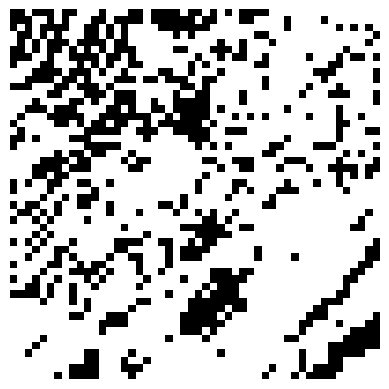

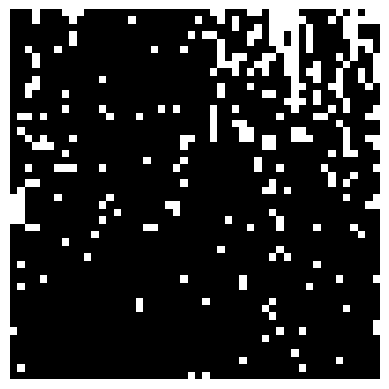

In [37]:
img = non_img_arr[0][0]
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


img = can_img_arr[0][0]
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [38]:
X = []
y = []

#breasextendt_img_arr = np.concatenate((non_img_arr[:12389], can_img_arr[:12389]))
#breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
breast_img_arr = non_img_arr+ can_img_arr
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)


In [39]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 20000
Number of IDC(-) Images: 10000
Number of IDC(+) Images: 10000
Image shape (Width, Height, Channels): (50, 50, 3)


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

#from tensorflow.keras.utils import to_categorical
#Y_train = to_categorical(Y_train, num_classes = 2)
#Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (16000, 50, 50, 3)
Testing Data Shape: (4000, 50, 50, 3)


In [41]:
def describeData(y):
    print('Number of IDC(-) Images: {}'.format(np.sum(y==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(y==1)))
describeData(Y_test)

Number of IDC(-) Images: 2011
Number of IDC(+) Images: 1989


In [42]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Model

# VGG16 MODEL

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16


vgg_model=VGG16(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
#model.summary()

In [17]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
  5/250 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5122 - loss: 9.6540 

I0000 00:00:1712586209.825934    2119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 52ms/step - accuracy: 0.7006 - loss: 1.1906 - val_accuracy: 0.7322 - val_loss: 0.5630
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7493 - loss: 0.5241 - val_accuracy: 0.7430 - val_loss: 0.5229
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7546 - loss: 0.5055 - val_accuracy: 0.7420 - val_loss: 0.5397
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7627 - loss: 0.4938 - val_accuracy: 0.7510 - val_loss: 0.5278
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7643 - loss: 0.4899 - val_accuracy: 0.7473 - val_loss: 0.5120
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7800 - loss: 0.4693 - val_accuracy: 0.7538 - val_loss: 0.5224
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7853 - loss: 0.4575 - val_accuracy: 0.7312 - val_loss: 0.5679
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7997 - loss: 0.4360 - val_accurac

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


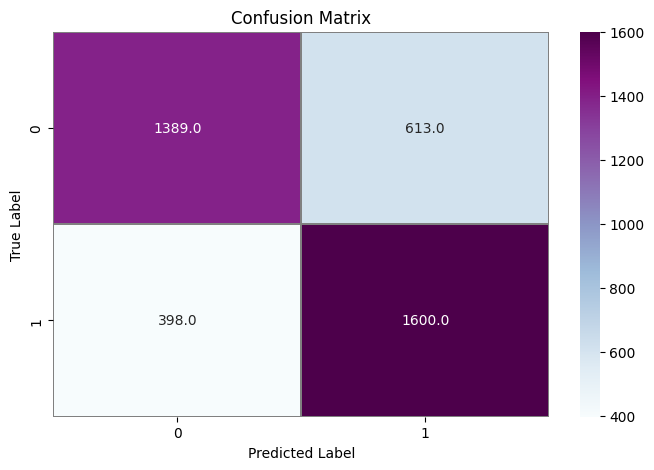

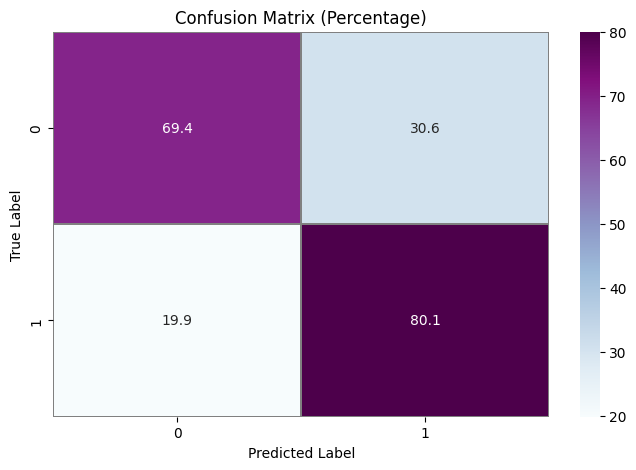

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7455 - loss: 0.5137
[0.5119453072547913, 0.7472500205039978]

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      2002
           1       0.72      0.80      0.76      1998

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))


# VGG19 MODEL

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg_model=VGG19(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
#model.summary()

In [20]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.6687 - loss: 1.4266 - val_accuracy: 0.7143 - val_loss: 0.5613
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7313 - loss: 0.5414 - val_accuracy: 0.7275 - val_loss: 0.5442
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7423 - loss: 0.5280 - val_accuracy: 0.7387 - val_loss: 0.5527
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7423 - loss: 0.5226 - val_accuracy: 0.7355 - val_loss: 0.5306
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7512 - loss: 0.5138 - val_accuracy: 0.7408 - val_loss: 0.5260
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7567 - loss: 0.4990 - val_accuracy: 0.7445 - val_loss: 0.5292
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7612 - loss: 0.4964 - val_accuracy: 0.7448 - val_loss: 0.5218
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7686 - loss: 0.4831 - 

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


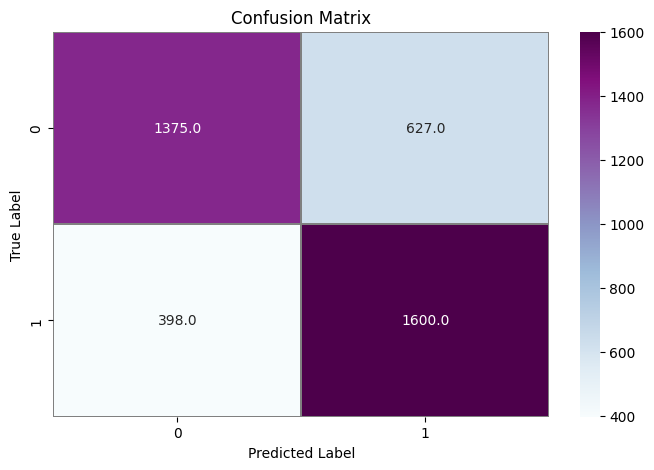

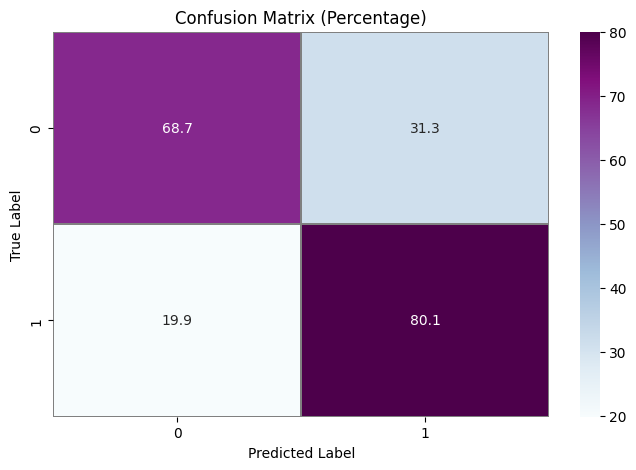

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7397 - loss: 0.5257
[0.5212022066116333, 0.7437499761581421]

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      2002
           1       0.72      0.80      0.76      1998

    accuracy                           0.74      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.75      0.74      0.74      4000



In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))

# ResNET_50

In [22]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model (without the top classification layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet50 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)
#model.summary()

In [23]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
  2/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5664 - loss: 1.1426   

I0000 00:00:1712588940.250691      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - accuracy: 0.6868 - loss: 0.7748 - val_accuracy: 0.6942 - val_loss: 0.5854
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8244 - loss: 0.4265 - val_accuracy: 0.7437 - val_loss: 0.5995
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9231 - loss: 0.2245 - val_accuracy: 0.7120 - val_loss: 0.7773
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9499 - loss: 0.1540 - val_accuracy: 0.7423 - val_loss: 0.7616
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9850 - loss: 0.0594 - val_accuracy: 0.7380 - val_loss: 0.8603
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9912 - loss: 0.0359 - val_accuracy: 0.7305 - val_loss: 0.9542
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9907 - loss: 0.0326 - val_accuracy: 0.7427 - val_loss: 0.9725
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9830 - loss: 0.0507 - val_accurac

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


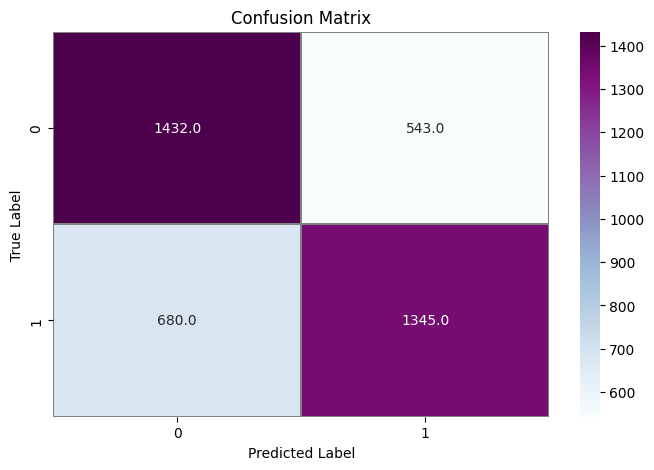

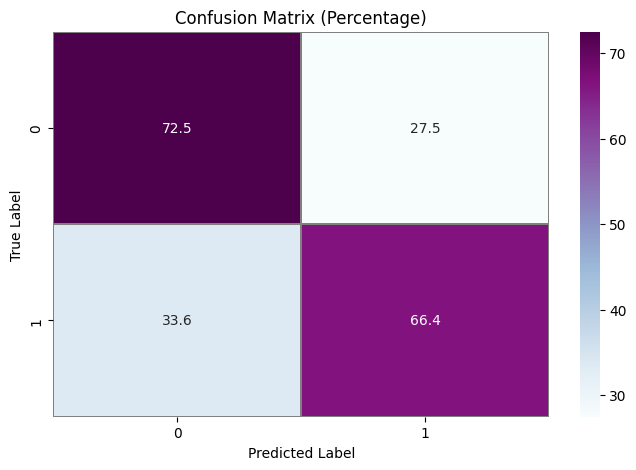

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6920 - loss: 0.5744
[0.5853309035301208, 0.6942499876022339]

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      1975
           1       0.71      0.66      0.69      2025

    accuracy                           0.69      4000
   macro avg       0.70      0.69      0.69      4000
weighted avg       0.70      0.69      0.69      4000



In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))

# ResNet 150

In [43]:
from tensorflow.keras.applications import ResNet152


# Load the pre-trained ResNet152 model (without the top classification layer)
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet152 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)

#model.summary()

In [44]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 203s 199ms/step - accuracy: 0.6927 - loss: 0.8708 - val_accuracy: 0.6927 - val_loss: 28.1964
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.7793 - loss: 0.5572 - val_accuracy: 0.7303 - val_loss: 25.2228
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - accuracy: 0.8743 - loss: 0.3608 - val_accuracy: 0.6867 - val_loss: 2.0973
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.9296 - loss: 0.2087 - val_accuracy: 0.7318 - val_loss: 2.7856
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.9676 - loss: 0.1131 - val_accuracy: 0.7185 - val_loss: 0.8676
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.9803 - loss: 0.0676 - val_accuracy: 0.7305 - val_loss: 1.2334
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.9890 - loss: 0.0405 - val_accuracy: 0.7237 - val_loss: 1.4291
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.9911 - loss

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step


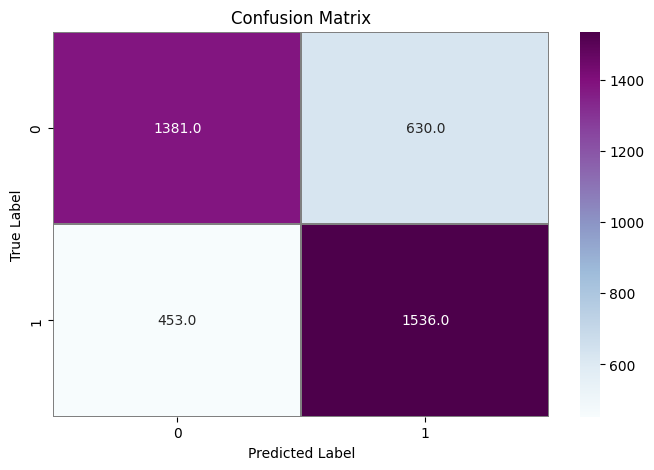

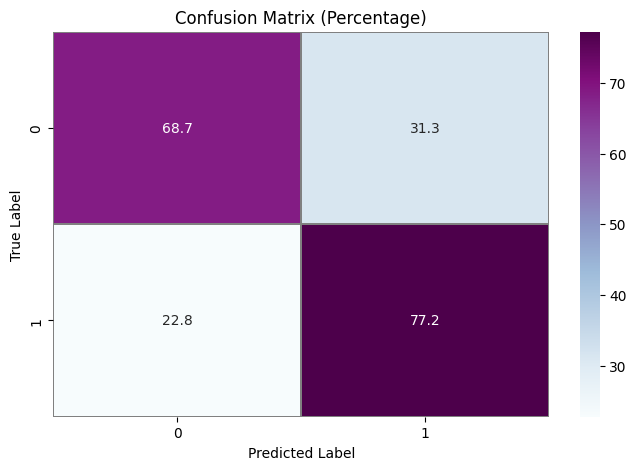

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7313 - loss: 0.6885
[0.6799047589302063, 0.7292500138282776]

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      2011
           1       0.71      0.77      0.74      1989

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))



# DenseNet121

In [47]:
from tensorflow.keras.applications import DenseNet121

# Load the pre-trained DenseNet121 model (without the top classification layer)
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the DenseNet121 base model
x = Flatten()(densenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=densenet_model.input, outputs=prediction)
#model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 171s 153ms/step - accuracy: 0.6721 - loss: 0.6968 - val_accuracy: 0.7435 - val_loss: 0.5405
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7536 - loss: 0.5162 - val_accuracy: 0.7558 - val_loss: 0.5269
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7973 - loss: 0.4473 - val_accuracy: 0.7483 - val_loss: 0.5226
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.8314 - loss: 0.3874 - val_accuracy: 0.7278 - val_loss: 0.5918
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.8794 - loss: 0.2959 - val_accuracy: 0.7082 - val_loss: 0.7144
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9233 - loss: 0.2043 - val_accuracy: 0.7245 - val_loss: 0.7965
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.9460 - loss: 0.1487 - val_accuracy: 0.7182 - val_loss: 0.9346
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9504 - loss: 0.1305 

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


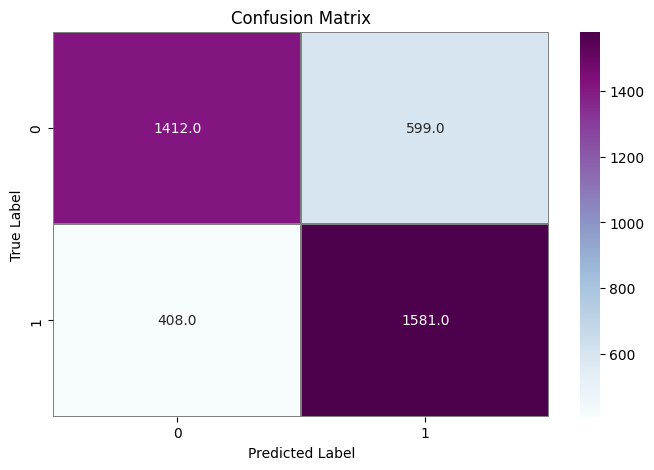

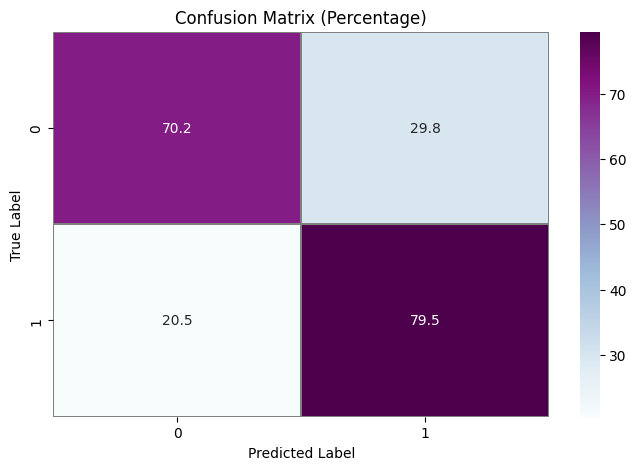

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7465 - loss: 0.5294
[0.5223892331123352, 0.7482500076293945]

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      2011
           1       0.73      0.79      0.76      1989

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))



# EfficientNetB0

In [50]:
from tensorflow.keras.applications import EfficientNetB0

# Load the pre-trained EfficientNetB0 model (without the top classification layer)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the EfficientNetB0 base model
x = Flatten()(efficientnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=efficientnet_model.input, outputs=prediction)
#model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [51]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 108s 83ms/step - accuracy: 0.6564 - loss: 0.7031 - val_accuracy: 0.6200 - val_loss: 0.7249
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7583 - loss: 0.5094 - val_accuracy: 0.6747 - val_loss: 0.6342
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8001 - loss: 0.4345 - val_accuracy: 0.7015 - val_loss: 0.6179
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8435 - loss: 0.3607 - val_accuracy: 0.7180 - val_loss: 0.6139
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8749 - loss: 0.3072 - val_accuracy: 0.7278 - val_loss: 0.6250
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9013 - loss: 0.2552 - val_accuracy: 0.7235 - val_loss: 0.6376
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9187 - loss: 0.2163 - val_accuracy: 0.7253 - val_loss: 0.6813
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9336 - loss: 0.1842 - va

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


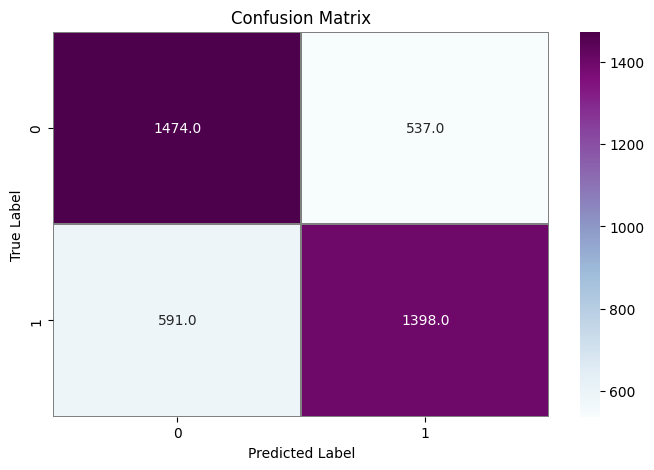

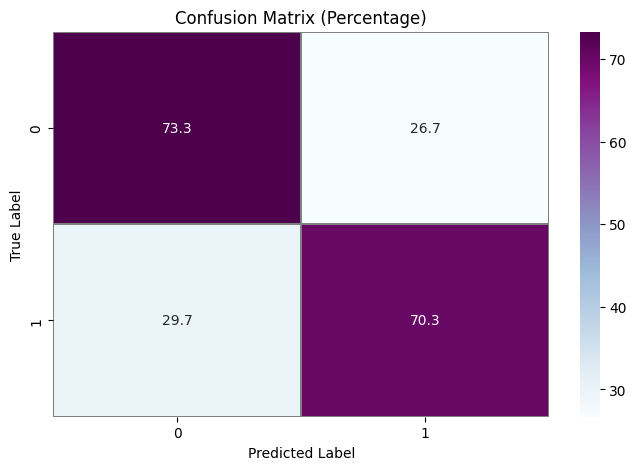

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7302 - loss: 0.6084
[0.6137233376502991, 0.7179999947547913]

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2011
           1       0.72      0.70      0.71      1989

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))


# MobileNetV2

In [53]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model (without the top classification layer)
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the MobileNetV2 base model
x = Flatten()(mobilenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=mobilenet_model.input, outputs=prediction)
#model.summary()

/tmp/ipykernel_35/1739306031.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))


In [54]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.6604 - loss: 0.7459 - val_accuracy: 0.6685 - val_loss: 0.7163
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.7473 - loss: 0.5224 - val_accuracy: 0.7285 - val_loss: 0.6593
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7701 - loss: 0.4789 - val_accuracy: 0.7372 - val_loss: 0.6244
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8020 - loss: 0.4324 - val_accuracy: 0.7395 - val_loss: 0.6060
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8247 - loss: 0.3923 - val_accuracy: 0.7405 - val_loss: 0.5923
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8400 - loss: 0.3596 - val_accuracy: 0.7280 - val_loss: 0.6159
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8605 - loss: 0.3269 - val_accuracy: 0.7370 - val_loss: 0.6263
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8842 - loss: 0.2799 - val_acc

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


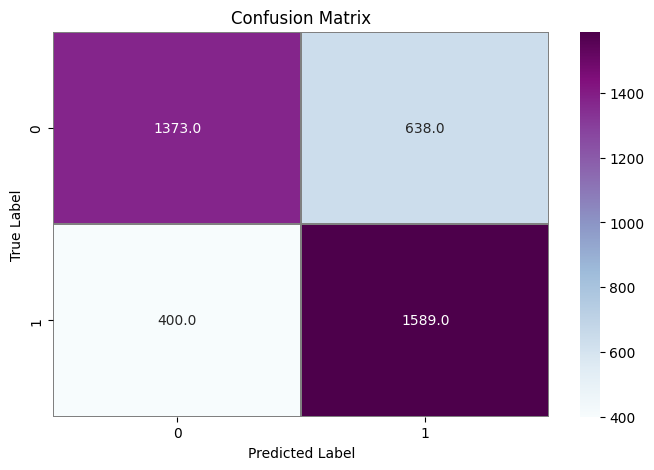

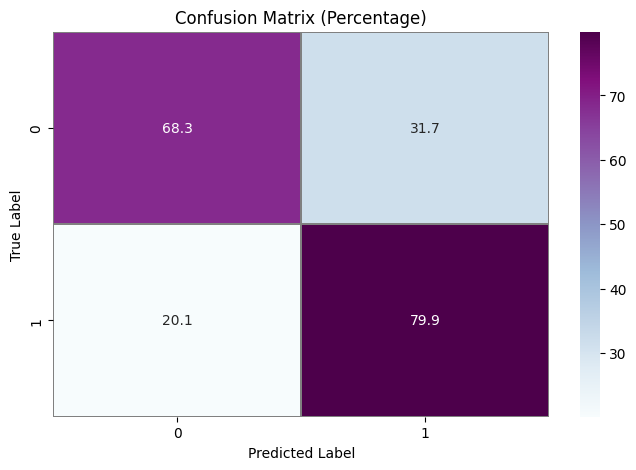

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7377 - loss: 0.5902
[0.5915995836257935, 0.7404999732971191]

              precision    recall  f1-score   support

           0       0.77      0.68      0.73      2011
           1       0.71      0.80      0.75      1989

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))
